# Statoil/C-CORE Iceberg Classifier Challenge

**Summary : ** Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

## Preliminaries and Imports

In [1]:
#general & system\n",
import os

#data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data augmentation
from random import choice
import cv2
import numpy as np
#import keras.preprocessing.image as prep

#ML part
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout,Activation,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


## I. Load Data

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
%%time
train = pd.read_json('../data/processed/train.json')
test = pd.read_json('../data/processed/test.json')

CPU times: user 5.68 s, sys: 944 ms, total: 6.63 s
Wall time: 6.62 s


- **Rq : ** Recast Numerical values into float as opposed to string encoding.

In [3]:
#recast inc_val as float
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'],errors='coerce')

- **Visual on the datasets**

In [4]:
print("Train raw dataset is of dimension : %sx%s"  %(train.shape))
train.head()

Train raw dataset is of dimension : 1604x5


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
print("Test raw dataset is of dimension : %sx%s"  %(test.shape))
test.head()

Test raw dataset is of dimension : 8424x4


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


In [6]:
#plot comparison between band_1 and band_2:
def plot_compband(df,size=4):
    df = df.sample(n=size*size,random_state=42)
    fig = plt.figure(1,figsize=(15,15))
    for i in range(size*size):
        ax = fig.add_subplot(size,size,i+1)
        arr = np.reshape(np.array(df.iloc[i,i%2]),(75,75))
        ax.imshow(arr,cmap='inferno')
        ax.text(5, 4, 'Id: %s %s' % (df.iloc[i,2], df.columns[i%2]), color='k', backgroundcolor='m', alpha=0.8)
        ax.text(5, 10, 'inc_angle: (%.4f)' % df.iloc[i,3], color='w', backgroundcolor='k', alpha=0.8)
        try:
            ax.text(5, 16, 'is_iceberg: %s' % df.iloc[i,4], color='k', backgroundcolor='w', alpha=0.8)
        except:
            pass
        ax.grid()
    plt.show()

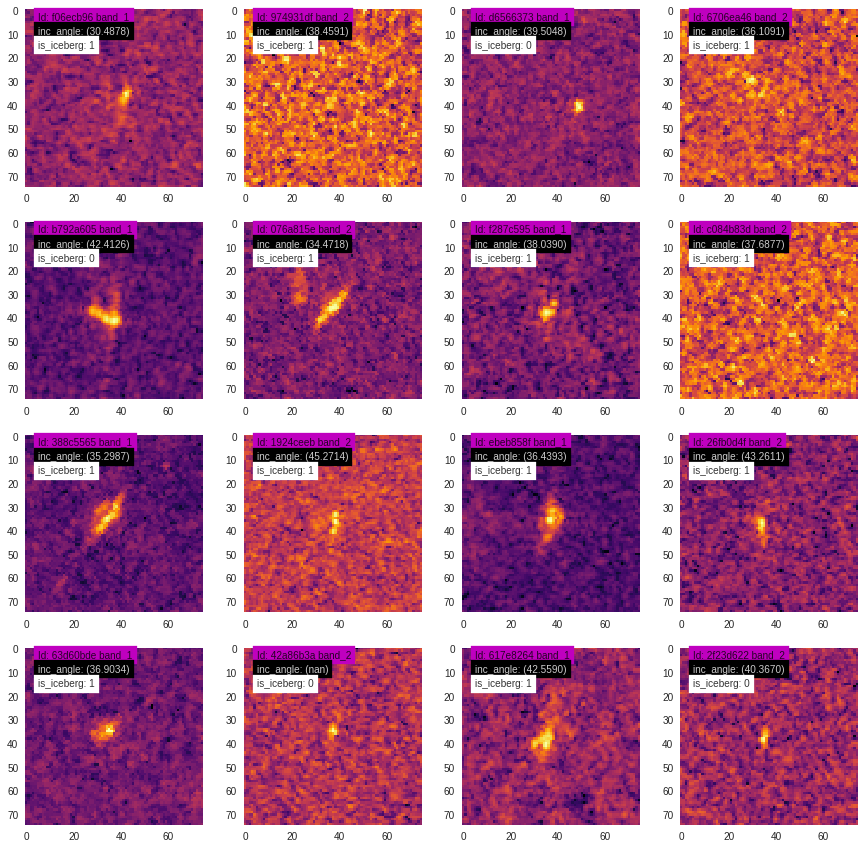

In [7]:
plot_compband(train)

In [8]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):
    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    
index=train[train["is_iceberg"]==1].sample(n=1,random_state=42).index[0]
plotmy3d(np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])[index,:,:],
         train.is_iceberg[index])

## II. Data Preparation

- **Case when the inc_angle is missing **

In [9]:
# plot_compband(train[train[\"inc_angle\"].isnull()])

In [10]:
#data imputation for inc_angle
    #smarter methods for later
train["inc_angle"] = train["inc_angle"].fillna(train["inc_angle"].mean())

In [11]:
def color_composite(data,target_size = 224):
    w,h = target_size,target_size
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        #Add in to resize for resnet50 use 197 x 197
        rgb = cv2.resize(rgb, (w,h)).astype(np.float32)
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [12]:
%%time
#data formating
X_train = color_composite(train,target_size=150)
X_test = color_composite(test,target_size=150)
Y_train = train["is_iceberg"]

CPU times: user 5.65 s, sys: 420 ms, total: 6.07 s
Wall time: 6.07 s


In [13]:
#data splitting
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, random_state=42, train_size=0.80)

## III. Deep Learning with Transfer Learning

In [14]:
weights_path = 'model/checkpoints/'

if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
epochs = 50
batch_size = 50

- **Using VGG16 : **

In [15]:
#load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [16]:
#adding top layers
    #sequentialy
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:])) #Flatten/GlobalAveragePooling2D
add_model.add(Dense(1024, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [17]:
#freeze lower layers of the model
#for layer in model.layers[:]:
    #layer.trainable = False
for layer in model.layers[0:]:
    layer.trainable = True
    
#compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
%%time
#Lets define the image transormations that we wan

gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         rotation_range=40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_one_input(X1, y):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]

#Finally create out generator
gen_flow = gen_flow_for_one_input(X_train, y_train)

from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs_to_wait_for_improve = 50
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint(weights_path + 'BestKerasModelVGG16_flat.h5', monitor='val_loss',
                                      verbose=1, save_best_only=True, mode='min')
#fit the model
model.fit_generator(gen_flow, validation_data=(X_valid, y_valid),
                    steps_per_epoch=int(np.ceil(len(X_train)/batch_size)),
                    epochs=500, verbose=1, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/500
25/25 [==============================] - 36s 1s/step - loss: 0.6979 - acc: 0.5472 - val_loss: 0.6379 - val_acc: 0.6854
Epoch 2/500
25/25 [==============================] - 33s 1s/step - loss: 0.6383 - acc: 0.6291 - val_loss: 0.5972 - val_acc: 0.6947
Epoch 3/500
25/25 [==============================] - 29s 1s/step - loss: 0.6108 - acc: 0.6483 - val_loss: 0.5745 - val_acc: 0.6854
Epoch 4/500
25/25 [==============================] - 29s 1s/step - loss: 0.5922 - acc: 0.6471 - val_loss: 0.5684 - val_acc: 0.6947
Epoch 5/500
25/25 [==============================] - 29s 1s/step - loss: 0.5878 - acc: 0.6543 - val_loss: 0.5421 - val_acc: 0.7040
Epoch 6/500
25/25 [==============================] - 29s 1s/step - loss: 0.5604 - acc: 0.6939 - val_loss: 0.5265 - val_acc: 0.7196
Epoch 7/500
25/25 [==============================] - 29s 1s/step - loss: 0.5517 - acc: 0.6855 - val_loss: 0.5175 - val_acc: 0.7259
Epoch 8/500
25/25 [==============================] - 29s 1s/step - loss: 0.5266 - a

25/25 [==============================] - 29s 1s/step - loss: 0.3522 - acc: 0.8427 - val_loss: 0.3150 - val_acc: 0.8505
Epoch 29/500
25/25 [==============================] - 29s 1s/step - loss: 0.3527 - acc: 0.8399 - val_loss: 0.3112 - val_acc: 0.8567
Epoch 30/500
25/25 [==============================] - 29s 1s/step - loss: 0.3567 - acc: 0.8363 - val_loss: 0.3441 - val_acc: 0.8380
Epoch 31/500
25/25 [==============================] - 29s 1s/step - loss: 0.3423 - acc: 0.8395 - val_loss: 0.3797 - val_acc: 0.8287
Epoch 32/500
25/25 [==============================] - 29s 1s/step - loss: 0.3213 - acc: 0.8507 - val_loss: 0.3100 - val_acc: 0.8629
Epoch 33/500
25/25 [==============================] - 29s 1s/step - loss: 0.3471 - acc: 0.8359 - val_loss: 0.3491 - val_acc: 0.8411
Epoch 34/500
25/25 [==============================] - 29s 1s/step - loss: 0.3238 - acc: 0.8491 - val_loss: 0.3109 - val_acc: 0.8723
Epoch 35/500
25/25 [==============================] - 29s 1s/step - loss: 0.3389 - acc: 0

25/25 [==============================] - 29s 1s/step - loss: 0.3120 - acc: 0.8579 - val_loss: 0.3491 - val_acc: 0.8255
Epoch 60/500
25/25 [==============================] - 29s 1s/step - loss: 0.2992 - acc: 0.8559 - val_loss: 0.3236 - val_acc: 0.8598
Epoch 61/500
25/25 [==============================] - 29s 1s/step - loss: 0.2596 - acc: 0.8783 - val_loss: 0.3291 - val_acc: 0.8505
Epoch 62/500
25/25 [==============================] - 29s 1s/step - loss: 0.2809 - acc: 0.8679 - val_loss: 0.3474 - val_acc: 0.8536
Epoch 63/500
25/25 [==============================] - 29s 1s/step - loss: 0.3268 - acc: 0.8459 - val_loss: 0.3535 - val_acc: 0.8380
Epoch 64/500
25/25 [==============================] - 29s 1s/step - loss: 0.2907 - acc: 0.8760 - val_loss: 0.3074 - val_acc: 0.8598
Epoch 65/500
25/25 [==============================] - 29s 1s/step - loss: 0.2771 - acc: 0.8811 - val_loss: 0.3501 - val_acc: 0.8505
Epoch 66/500
25/25 [==============================] - 29s 1s/step - loss: 0.2745 - acc: 0

Epoch 92/500
25/25 [==============================] - 29s 1s/step - loss: 0.2724 - acc: 0.8716 - val_loss: 0.3391 - val_acc: 0.8349
Epoch 93/500
25/25 [==============================] - 29s 1s/step - loss: 0.2794 - acc: 0.8816 - val_loss: 0.3175 - val_acc: 0.8505
Epoch 94/500
25/25 [==============================] - 29s 1s/step - loss: 0.2770 - acc: 0.8839 - val_loss: 0.3186 - val_acc: 0.8567
Epoch 95/500
25/25 [==============================] - 29s 1s/step - loss: 0.2516 - acc: 0.8908 - val_loss: 0.2879 - val_acc: 0.8847
Epoch 96/500
25/25 [==============================] - 29s 1s/step - loss: 0.2386 - acc: 0.8944 - val_loss: 0.3213 - val_acc: 0.8660
Epoch 97/500
25/25 [==============================] - 29s 1s/step - loss: 0.2704 - acc: 0.8836 - val_loss: 0.3122 - val_acc: 0.8536
Epoch 98/500
25/25 [==============================] - 29s 1s/step - loss: 0.2499 - acc: 0.8964 - val_loss: 0.3090 - val_acc: 0.8723
Epoch 99/500
25/25 [==============================] - 29s 1s/step - loss: 0.

Epoch 125/500
25/25 [==============================] - 29s 1s/step - loss: 0.2301 - acc: 0.9031 - val_loss: 0.3338 - val_acc: 0.8598
Epoch 126/500
25/25 [==============================] - 29s 1s/step - loss: 0.2324 - acc: 0.9020 - val_loss: 0.3042 - val_acc: 0.8723
Epoch 127/500
25/25 [==============================] - 29s 1s/step - loss: 0.2418 - acc: 0.8971 - val_loss: 0.3249 - val_acc: 0.8660
Epoch 128/500
25/25 [==============================] - 29s 1s/step - loss: 0.2369 - acc: 0.9020 - val_loss: 0.3246 - val_acc: 0.8692
Epoch 129/500
25/25 [==============================] - 29s 1s/step - loss: 0.2317 - acc: 0.8992 - val_loss: 0.3827 - val_acc: 0.8349
Epoch 130/500
25/25 [==============================] - 29s 1s/step - loss: 0.2472 - acc: 0.8860 - val_loss: 0.2966 - val_acc: 0.8910
Epoch 131/500
25/25 [==============================] - 29s 1s/step - loss: 0.2338 - acc: 0.9016 - val_loss: 0.3288 - val_acc: 0.8660
Epoch 132/500
25/25 [==============================] - 29s 1s/step - 

25/25 [==============================] - 29s 1s/step - loss: 0.2187 - acc: 0.9072 - val_loss: 0.3034 - val_acc: 0.8723
Epoch 159/500
25/25 [==============================] - 29s 1s/step - loss: 0.2070 - acc: 0.9156 - val_loss: 0.2887 - val_acc: 0.8847
Epoch 160/500
25/25 [==============================] - 29s 1s/step - loss: 0.2254 - acc: 0.9032 - val_loss: 0.2842 - val_acc: 0.8754
Epoch 161/500
25/25 [==============================] - 29s 1s/step - loss: 0.2167 - acc: 0.9024 - val_loss: 0.3106 - val_acc: 0.8754
CPU times: user 50min 37s, sys: 8min 35s, total: 59min 13s
Wall time: 1h 17min 33s


## IV. Evaluate Model

In [19]:
model = load_model(weights_path+"BestKerasModelVGG16_flat.h5")
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

321/321 [==============================] - 4s 13ms/step
('Test loss:', 0.28133481337668553)
('Test accuracy:', 0.88473520249221183)


In [20]:
#compute log loss
pred = model.predict(X_valid)
log_loss(y_valid,pred)

0.28133481913121999